In [ ]:
!pip install -q tensorflow_text
!pip install wandb
!pip install -q focal-loss

In [1]:
# References
# https://keras.io/examples/nlp/multimodal_entailment/
# https://www.tensorflow.org/text/tutorials/bert_glue

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import wandb 

In [ ]:
wandb.login()

In [2]:
run = wandb.init(
    project="multimodality-learning", 
    job_type='training'
)

wandb: Currently logged in as: shilu4577. Use `wandb login --relogin` to force relogin


In [3]:
ROBERTA_PREPROCESSOR_PATH = "https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1"
ROBERTA_ENCODER_PATH ="https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1"
LABEL_MAP = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}
IMAGE_DIR_PATH = 'tweet_images/'
IMG_SHAPE = (128, 128)
ROBERTA_INPUT_FEATURES = ["input_word_ids", "input_type_ids", "input_mask"]
BATCH_SIZE  = 32 
AUTO =  tf.data.AUTOTUNE
INPUT_DIMS = (128, 128, 3)

In [ ]:
run.config["ROBERTA_PREPROCESSOR_PATH"] = "https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1"
run.config["ROBERTA_ENCODER_PATH"] = "https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1"
run.config["LABEL_MAP"] = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}
run.config["IMAGE_DIR_PATH"] = 'tweet_images/'
run.config["IMG_SHAPE"] = (128, 128)
run.config["ROBERTA_INPUT_FEATURES"] = ["input_word_ids", "input_type_ids", "input_mask"]
run.config["BATCH_SIZE"] =  32 
run.config["AUTO"] = tf.data.AUTOTUNE
run.config["INPUT_DIMS"] = (128, 128, 3)

In [ ]:
import os 

dataframe_url = "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
image_url =  "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz"

def get_data(dataframe_url, image_url):
    try:
        os.system(f"wget {dataframe_url} --quiet")
        os.system(f"wget {image_url} --quiet")
        os.system("tar -xzf tweet_images.tar.gz")
        
    except Exception as error: 
        return error
    
get_data(dataframe_url, image_url)
df = pd.read_csv("tweets.csv")

In [ ]:
artifact = wandb.Artifact(name='tweet-dataframe-before-edit', type='dataset')
artifact.add_file("tweets.csv")
run.log_artifact(artifact)

In [4]:
artifact = run.use_artifact('tweet-dataframe-before-edit:latest')
dataframe_file = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
artifact = wandb.Artifact(name='tweet-images-dir-before-edit', type='dataset')
artifact.add_dir("tweet_images/")
run.log_artifact(artifact)

In [5]:
artifact = run.use_artifact('tweet-images-dir-before-edit:latest')
data_dir = artifact.download()

wandb: Downloading large artifact tweet-images-dir-before-edit:latest, 339.94MB. 2803 files... 
wandb:   2803 of 2803 files downloaded.  
Done. 0:0:1.1


In [6]:
def create_images_path(image_data_dir_path, df, label_map):
    
    images_one_paths = []
    images_two_paths = []

    for idx in range(len(df)):
        current_row = df.iloc[idx]
        id_1 = current_row["id_1"]
        id_2 = current_row["id_2"]
        extentsion_one = current_row["image_1"].split(".")[-1]
        extentsion_two = current_row["image_2"].split(".")[-1]

        image_one_path = os.path.join(image_data_dir_path, str(id_1) + f".{extentsion_one}")
        image_two_path = os.path.join(image_data_dir_path, str(id_2) + f".{extentsion_two}")

        images_one_paths.append(image_one_path)
        images_two_paths.append(image_two_path)

    df["image_1_path"] = images_one_paths
    df["image_2_path"] = images_two_paths


    df["label_idx"] = df["label"].apply(lambda x: label_map[x])
    
    return images_one_paths, images_two_paths

In [ ]:
df = pd.read_csv(dataframe_file+"/tweets.csv")
images_one_paths, images_two_paths = create_images_path(data_dir, df, LABEL_MAP)

In [ ]:
df.to_csv("tweets_after_edit.csv")

artifact = wandb.Artifact(name='tweet-dataframe-after-edit', type='dataset')
artifact.add_file("tweets_after_edit.csv")
run.log_artifact(artifact)

In [7]:
artifact = run.use_artifact('tweet-dataframe-after-edit:latest')
tweet_after_edit_path = artifact.download()

df = pd.read_csv(tweet_after_edit_path + "/tweets_after_edit.csv")
df.head()

wandb:   1 of 1 files downloaded.  


,Unnamed: 0,id_1,text_1,image_1,id_2,text_2,image_2,label,image_1_path,image_2_path,label_idx
0,0,1375936088968200205,"150 years after its inauguration, the strategi...",http://pbs.twimg.com/media/ExeIVRBWYAAwizQ.jpg,1376653595144241155,Look how only 190 km #suezcanel carries 12% of...,http://pbs.twimg.com/media/ExrbJffWgAoBaxO.jpg,NoEntailment,./artifacts/tweet-dataset-before-edit:v0/13759...,./artifacts/tweet-dataset-before-edit:v0/13766...,2
1,1,1360981123388436489,Fall Guys is celebrating Valentine's Day with ...,http://pbs.twimg.com/media/EuMowPiXYAEylR8.jpg,1361075903606910976,Fall Guys Red Panda costume available for limi...,http://pbs.twimg.com/media/EuODUixWYAMRukK.jpg,NoEntailment,./artifacts/tweet-dataset-before-edit:v0/13609...,./artifacts/tweet-dataset-before-edit:v0/13610...,2
2,2,1336637206899945472,Impressive Batting Display From Shoaib Malik 🏏...,http://pbs.twimg.com/media/EoywcVGXMAE5FZK.jpg,1339243901799030785,"A Half century of King\n\n 🔥""Shoaib Malik"" ...",http://pbs.twimg.com/media/EpXzOwRXYAYLaCB.jpg,NoEntailment,./artifacts/tweet-dataset-before-edit:v0/13366...,./artifacts/tweet-dataset-before-edit:v0/13392...,2
3,3,1336490796279742464,How #confident are you today? https://t.co/5ay...,http://pbs.twimg.com/media/EowrS9aVEAAMhsF.jpg,1341081069248868353,How #confident are you today? https://t.co/KqZ...,http://pbs.twimg.com/media/Epx6IA-UwAA8pqN.jpg,Implies,./artifacts/tweet-dataset-before-edit:v0/13364...,./artifacts/tweet-dataset-before-edit:v0/13410...,1
4,4,1358934899256877059,The Peacocks finish out the first quarter trai...,http://pbs.twimg.com/media/EtvoCsuWQAALmyP.jpg,1361131487077228546,10 minutes gone here at home as the Peacocks l...,http://pbs.twimg.com/media/EuO1xf2XIAAOIGb.jpg,NoEntailment,./artifacts/tweet-dataset-before-edit:v0/13589...,./artifacts/tweet-dataset-before-edit:v0/13611...,2


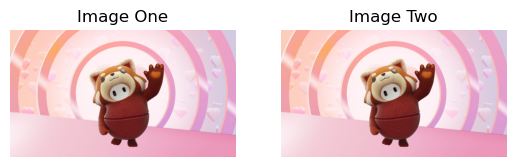

Text one: Fall Guys is celebrating Valentine's Day with a lovable new Red Panda costume. https://t.co/TeC8f2UTz1 https://t.co/k0oKveAbyc
Text two: Fall Guys Red Panda costume available for limited time

https://t.co/oMuJo7M2FT https://t.co/anb0IGj6q1
Label: NoEntailment


In [8]:
def visualize(df, data_index): 
    try: 
        current_row = df.iloc[data_index]
        image_1 = plt.imread(current_row["image_1_path"])
        image_2 = plt.imread(current_row["image_2_path"])
        text_1 = current_row["text_1"]
        text_2 = current_row["text_2"]
        label = current_row["label"]

        plt.subplot(1, 2, 1)
        plt.imshow(image_1)
        plt.axis("off")
        plt.title("Image One")
        plt.subplot(1, 2, 2)
        plt.imshow(image_1)
        plt.axis("off")
        plt.title("Image Two")
        plt.show()

        print(f"Text one: {text_1}")
        print(f"Text two: {text_2}")
        print(f"Label: {label}")
    
    except Exception as error:
        return error
    
visualize(df, 1)

In [9]:
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

In [10]:
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)

In [11]:
def build_roberta_preprocessor(preprocessor_path):
    # Reference : https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1
    """Returns Model mapping string features to BERT inputs.

      Args:
        sentence_features: A list with the names of string-valued features.
        seq_length: An integer that defines the sequence length of BERT inputs.

      Returns:
        A Keras Model that can be called on a list or dict of string Tensors
        (with the order or names, resp., given by sentence_features) and
        returns a dict of tensors for input to BERT.
  """
    
    text_inputs = [
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        tf.keras.layers.Input(shape=(), dtype=tf.string),
    ]
    
    #roberta preprocessor
    preprocessor = hub.load(preprocessor_path)
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs)
    
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    
    return keras.Model(text_inputs, encoder_inputs)

roberta_preprocessor_model = build_roberta_preprocessor(ROBERTA_PREPROCESSOR_PATH)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [12]:
# testing the roberta preprocessor 

hypotheses = tf.constant(["(your hypothesis text here)"])
premises = tf.constant(["(your premise text here)"])
preprocessed_txt = roberta_preprocessor_model([hypotheses, premises])
print(f"Text1: {hypotheses}")
print(f"Text2: {premises}")

print("Keys           : ", list(preprocessed_txt.keys()))
print("Shape Word Ids : ", preprocessed_txt["input_word_ids"].shape)
print("Word Ids       : ", preprocessed_txt["input_word_ids"][0, :16])
print("Shape Mask     : ", preprocessed_txt["input_mask"].shape)
print("Input Mask     : ", preprocessed_txt["input_mask"][0, :16])
print("Shape Type Ids : ", preprocessed_txt["input_type_ids"].shape)
print("Type Ids       : ", preprocessed_txt["input_type_ids"][0, :16])

Text1: [b'(your hypothesis text here)']
Text2: [b'(your premise text here)']
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[    0  1640 16625 31098  2788   259    43     2     2  1640 16625 18805
  2788   259    43     2], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [13]:
def dataframe_to_tensor_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [14]:
def reshape_image(image_path, img_shape):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, img_shape)
    return image

def get_encoder_input(roberta_preprocessor_model, text_1, text_2, roberta_input_features):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    encoder_inputs = roberta_preprocessor_model([text_1, text_2])
    encoder_inputs = {feature: tf.squeeze(encoder_inputs[feature]) for feature in roberta_input_features}
    return encoder_inputs

def preprocess_text_and_image(sample, roberta_preprocessor_model, roberta_input_features, img_shape):
    image_1 = reshape_image(sample["image_1_path"], img_shape)
    image_2 = reshape_image(sample["image_2_path"], img_shape)
    encoder_inputs = get_encoder_input(roberta_preprocessor_model, sample["text_1"], sample["text_2"], roberta_input_features)
    return {"image_1": image_1, "image_2": image_2, "text": encoder_inputs}

In [15]:
def prepare_dataset(dataframe, batch_size, auto, training=True):
    ds = dataframe_to_tensor_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x, roberta_preprocessor_model, ROBERTA_INPUT_FEATURES, IMG_SHAPE), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df, BATCH_SIZE, AUTO)
test_ds = prepare_dataset(test_df,BATCH_SIZE, AUTO, False)

In [16]:
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


def create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):

    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")


def create_text_encoder(roberta_encoder_path, bert_input_features, 
                                num_projection_layers, projection_dims, dropout_rate, trainable=False):
    roberta = hub.KerasLayer(roberta_encoder_path, name="bert",)
    roberta.trainable = trainable
    
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    embeddings = roberta(text_inputs)["pooled_output"]

    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    return keras.Model(text_inputs, outputs, name="text_encoder")


def create_multimodal_model(roberta_encoder_path, img_input_dims, bert_input_features, num_projection_layers=1, 
                                    projection_dims=256, dropout_rate=0.1, vision_trainable=False, text_trainable=False, rate=0.2):
    
    image_1 = keras.Input(shape=img_input_dims, name="image_1")
    image_2 = keras.Input(shape=img_input_dims, name="image_2")

    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        roberta_encoder_path, bert_input_features, num_projection_layers, projection_dims, dropout_rate, text_trainable
    )
    
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)
    vision_projections = keras.layers.Dropout(rate)(vision_projections)
    text_projections = keras.layers.Dropout(rate)(text_projections)
    
    query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)([vision_projections, text_projections])

    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    contextual = keras.layers.Concatenate()([concatenated, query_value_attention_seq])

    outputs = keras.layers.Dense(3, activation="softmax")(contextual)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model(ROBERTA_ENCODER_PATH, INPUT_DIMS, ROBERTA_INPUT_FEATURES)

In [17]:
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(train_ds, training=True)
        loss = loss_fn(y, logits)
    
    model_params = model.trainable_weights
    grads = tape.gradient(loss_value, model_params)
    optimizer.apply_gradients(zip(grads, model_params))
    train_acc_metric.update_state(y, logits)

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

def manual_train(train_dataset,
          val_dataset, 
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=10, 
          log_step=200, 
          val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # 3️⃣ log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

In [ ]:
sweep_config = {
    'method': 'bayes',
    'name': 'hyperparameter-multimodal',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
        },
    'parameters': {
        'epochs': {'values': [10, 15]},
        'lr': {'max': 00.1, 'min': 0.0001, 'distribution': 'uniform'},
        'optimizer': {
        'values': ['adam', 'sgd']
        },
     }
}


In [18]:
from focal_loss import SparseCategoricalFocalLoss
import tensorflow_addons as tfa

def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)

    
def train_model(multimodal_model, epochs, lr, batch_size, optimizer, train_labels, train_ds, test_ds): 
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=5),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}")
    ]


    train_labels_ohe = keras.utils.to_categorical(train_labels)
    class_totals = train_labels_ohe.sum(axis=0)
    class_weight = dict()

    for i in range(0, len(class_totals)):
        class_weight[i] = class_totals.max() / class_totals[i]
    
    opt = get_optimizer(lr, optimizer)
    
    multimodal_model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", 
                                             metrics="accuracy")
    multimodal_model.fit(train_ds, epochs=epochs, 
                                       validation_data=test_ds, batch_size=batch_size, 
                                       callbacks=wandb_callbacks, class_weight=class_weight)

In [ ]:
def get_labels(ds):
    labels = []
    for _, label in ds.unbatch():
        labels.append(label)
    labels = np.array(labels)
    return labels

train_labels = get_labels(train_ds)
test_labels = get_labels(test_ds)


def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        train(multimodal_model,  
              wandb.config.epochs,
              wandb.config.lr,
              BATCH_SIZE,
              wandb.config.optimizer,
              train_labels
             )

count = 10
sweep_id = wandb.sweep(sweep_config, project="multimodality-learning")
wandb.agent(sweep_id, function=sweep_train, count=count)

In [24]:
multimodal_model = create_multimodal_model(ROBERTA_ENCODER_PATH, INPUT_DIMS, ROBERTA_INPUT_FEATURES)
train_model(multimodal_model, 15, 0.0001, 32, "adam", train_labels)

Epoch 1/15
40/40 [==============================] - 24s 289ms/step - loss: 2.6809 - accuracy: 0.6317 - val_loss: 1.6383 - val_accuracy: 0.3571
Epoch 2/15
40/40 [==============================] - 9s 217ms/step - loss: 1.9229 - accuracy: 0.7063 - val_loss: 1.0922 - val_accuracy: 0.5786
Epoch 3/15
40/40 [==============================] - 9s 219ms/step - loss: 1.6767 - accuracy: 0.7516 - val_loss: 0.6810 - val_accuracy: 0.8571
Epoch 4/15
40/40 [==============================] - 9s 220ms/step - loss: 1.6963 - accuracy: 0.7508 - val_loss: 1.0448 - val_accuracy: 0.6500
Epoch 5/15
40/40 [==============================] - 9s 219ms/step - loss: 1.4811 - accuracy: 0.8135 - val_loss: 1.0359 - val_accuracy: 0.7357
Epoch 6/15
40/40 [==============================] - 9s 220ms/step - loss: 1.0502 - accuracy: 0.8690 - val_loss: 0.9113 - val_accuracy: 0.7643
Epoch 7/15
40/40 [==============================] - 9s 222ms/step - loss: 0.5105 - accuracy: 0.9381 - val_loss: 1.1094 - val_accuracy: 0.6786
Epoch

In [ ]:
from sklearn.metrics import * 

def get_classification_report(y_preds, y_true, class_names):
    report = classification_report(y_true, y_preds, target_names=class_names)
    return report

In [26]:
y_preds = multimodal_model.predict(test_ds)
y_preds = np.argmax(y_preds, 1)
print(get_classification_report(y_preds, test_labels, LABEL_MAP.keys()))

5/5 [==============================] - 1s 201ms/step
               precision    recall  f1-score   support

Contradictory       0.71      0.45      0.56        11
      Implies       0.09      0.09      0.09        11
 NoEntailment       0.89      0.92      0.91       118

     accuracy                           0.82       140
    macro avg       0.57      0.49      0.52       140
 weighted avg       0.82      0.82      0.82       140

